#Introduction

In this project, I am trying to create model to predict vehicle incurance claim fraud from data provided on kaggle
https://www.kaggle.com/shivamb/vehicle-claim-fraud-detection

#Imports

In [ ]:
!pip install optuna
!pip install catboost
# !pip install shap
!pip install catboost --no-cache-dir

In [ ]:
#Basic
import pathlib
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots

#Preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer

#Feature selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif
# from skfeature.function.similarity_based import fisher_score

#Metrics
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score, average_precision_score, accuracy_score, confusion_matrix

#Model building
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import optuna

#Models
import xgboost as xgb
import lightgbm as lgb
import catboost as ctb




from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from imblearn.ensemble import BalancedRandomForestClassifier

from sklearn.model_selection import cross_val_score

# import shap

%matplotlib inline

#Loading data

In [ ]:
path = pathlib.Path('/content/drive/MyDrive/Colab Notebooks/Moje Projekty/fraud_oracle.csv')
df = pd.read_csv(path)

#EDA

##Basic statistic

In [ ]:
df.head(5)

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfVehicle,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy
0,Dec,5,Wednesday,Honda,Urban,Tuesday,Jan,1,Female,Single,...,3 years,26 to 30,No,No,External,none,1 year,3 to 4,1994,Liability
1,Jan,3,Wednesday,Honda,Urban,Monday,Jan,4,Male,Single,...,6 years,31 to 35,Yes,No,External,none,no change,1 vehicle,1994,Collision
2,Oct,5,Friday,Honda,Urban,Thursday,Nov,2,Male,Married,...,7 years,41 to 50,No,No,External,none,no change,1 vehicle,1994,Collision
3,Jun,2,Saturday,Toyota,Rural,Friday,Jul,1,Male,Married,...,more than 7,51 to 65,Yes,No,External,more than 5,no change,1 vehicle,1994,Liability
4,Jan,5,Monday,Honda,Urban,Tuesday,Feb,2,Female,Single,...,5 years,31 to 35,No,No,External,none,no change,1 vehicle,1994,Collision


In [ ]:
df.head(5).T

,0,1,2,3,4
Month,Dec,Jan,Oct,Jun,Jan
WeekOfMonth,5,3,5,2,5
DayOfWeek,Wednesday,Wednesday,Friday,Saturday,Monday
Make,Honda,Honda,Honda,Toyota,Honda
AccidentArea,Urban,Urban,Urban,Rural,Urban
DayOfWeekClaimed,Tuesday,Monday,Thursday,Friday,Tuesday
MonthClaimed,Jan,Jan,Nov,Jul,Feb
WeekOfMonthClaimed,1,4,2,1,2
Sex,Female,Male,Male,Male,Female
MaritalStatus,Single,Single,Married,Married,Single


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15420 entries, 0 to 15419
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Month                 15420 non-null  object
 1   WeekOfMonth           15420 non-null  int64 
 2   DayOfWeek             15420 non-null  object
 3   Make                  15420 non-null  object
 4   AccidentArea          15420 non-null  object
 5   DayOfWeekClaimed      15420 non-null  object
 6   MonthClaimed          15420 non-null  object
 7   WeekOfMonthClaimed    15420 non-null  int64 
 8   Sex                   15420 non-null  object
 9   MaritalStatus         15420 non-null  object
 10  Age                   15420 non-null  int64 
 11  Fault                 15420 non-null  object
 12  PolicyType            15420 non-null  object
 13  VehicleCategory       15420 non-null  object
 14  VehiclePrice          15420 non-null  object
 15  FraudFound_P          15420 non-null

The DataFrame contains 15420 rows and 33 columns. There are no missing values. This indicates that most of the variables are of the "object" type, which typically contains text data or categories. Additionally, there are a few variables of the "int64" type.

In [ ]:
df.describe()

,WeekOfMonth,WeekOfMonthClaimed,Age,FraudFound_P,PolicyNumber,RepNumber,Deductible,DriverRating,Year
count,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000,15420.000000
mean,2.788586,2.693969,39.855707,0.059857,7710.500000,8.483268,407.704280,2.487808,1994.866472
std,1.287585,1.259115,13.492377,0.237230,4451.514911,4.599948,43.950998,1.119453,0.803313
min,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,300.000000,1.000000,1994.000000
25%,2.000000,2.000000,31.000000,0.000000,3855.750000,5.000000,400.000000,1.000000,1994.000000
50%,3.000000,3.000000,38.000000,0.000000,7710.500000,8.000000,400.000000,2.000000,1995.000000
75%,4.000000,4.000000,48.000000,0.000000,11565.250000,12.000000,400.000000,3.000000,1996.000000
max,5.000000,5.000000,80.000000,1.000000,15420.000000,16.000000,700.000000,4.000000,1996.000000


The provided summary statistics do not show any significant outliers except for the minimum age value of 0, which could potentially be a data entry error or require additional context to understand. Overall, the dataset seems to be within reasonable ranges for the variables, and further exploration can help identify any specific patterns or anomalies.

In [ ]:
sns.set_style('darkgrid')

<Axes: xlabel='FraudFound_P', ylabel='count'>

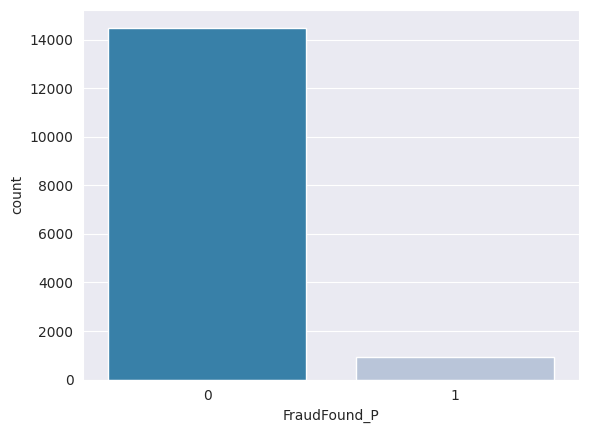

In [ ]:
sns.countplot(x='FraudFound_P', data=df, palette = 'PuBu_r')

The results indicate a significant imbalance in the dataset, with a large difference in the number of cases marked as 0 (non-fraud) compared to cases marked as 1 (fraud). This strong class imbalance can affect the effectiveness of analysis and modelling, so it is important to choose the right models.

In [ ]:
df.FraudFound_P.value_counts()

0    14497
1      923
Name: FraudFound_P, dtype: int64

##Graphs

'Sex'

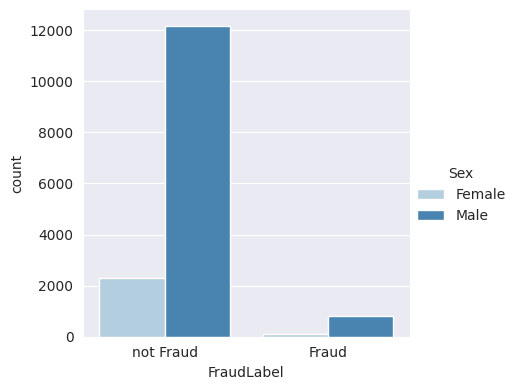

In [ ]:
df['FraudLabel'] = df['FraudFound_P'].map({0: 'not Fraud', 1: 'Fraud'})

sns.catplot(data=df, x='FraudLabel', hue='Sex', kind='count',
            palette='Blues', height=4, aspect=1.1)

'Month'

In [ ]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig = make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'))

fig1 = px.histogram(df[df['FraudFound_P']==1], x='Month', histnorm='probability')
fig2 = px.histogram(df[df['FraudFound_P']==0], x='Month', histnorm='probability')

fig.add_trace(fig1.data[0], row=1, col=1)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_xaxes(matches='x', categoryorder='array', categoryarray=month_order)

fig.update_layout(title_text='"Comparison of Fraud vs. Not Fraud"',
                  width=1000, height=500,
                  title_x=0.5)

fig.update_yaxes(range=[0, 0.12], row=1, col=1)
fig.update_yaxes(range=[0, 0.12], row=1, col=2)

fig.update_xaxes(title_text="Month", row=1, col=1)
fig.update_yaxes(title_text="Probability", row=1, col=1)

fig.update_xaxes(title_text="Month", row=1, col=2)
fig.update_yaxes(title_text="Probability", row=1, col=2)

The distribution of claims varies depending on whether they involve frauds or not

Text(0.5, 1.0, 'The Probability of Fraud for indyvidual months')

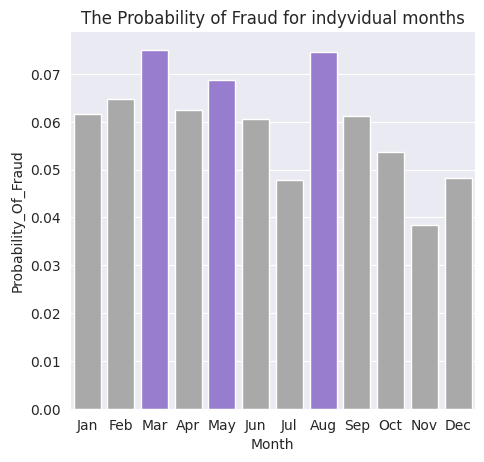

In [ ]:
df_month = pd.DataFrame(df.groupby('Month').FraudFound_P.mean().reset_index())
df_month.columns = ['Month', 'Probability_Of_Fraud']

month_palette = ['darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'mediumpurple', 'darkgray', 'darkgray', 'darkgray', 'darkgray']

sns.catplot(data=df_month, x='Month', y='Probability_Of_Fraud', kind='bar',
            palette=month_palette, order=month_order,
            height=4.5, aspect=1.1)
plt.title('The Probability of Fraud for indyvidual months')

Amongst fraudulent cases months of March, Aug and May has relatively higher probablity.

'MonthClaimed'

In [ ]:
df['MonthClaimed'].unique()

array(['Jan', 'Nov', 'Jul', 'Feb', 'Mar', 'Dec', 'Apr', 'Aug', 'May',
       'Jun', 'Sep', 'Oct', '0'], dtype=object)

In [ ]:
df[df['MonthClaimed']=='0']

,Month,WeekOfMonth,DayOfWeek,Make,AccidentArea,DayOfWeekClaimed,MonthClaimed,WeekOfMonthClaimed,Sex,MaritalStatus,...,AgeOfPolicyHolder,PoliceReportFiled,WitnessPresent,AgentType,NumberOfSuppliments,AddressChange_Claim,NumberOfCars,Year,BasePolicy,FraudLabel
1516,Jul,2,Monday,Honda,Rural,0,0,1,Male,Single,...,16 to 17,No,No,External,none,no change,1 vehicle,1994,All Perils,not Fraud


In [ ]:
df.drop(1516, axis=0, inplace=True)

The groups of the highest risk are 21 to 25, 18 to 20 and 16 to 17.

'Age'

[Text(0.5, 1.0, 'Not Fraud'), (0.0, 0.06)]

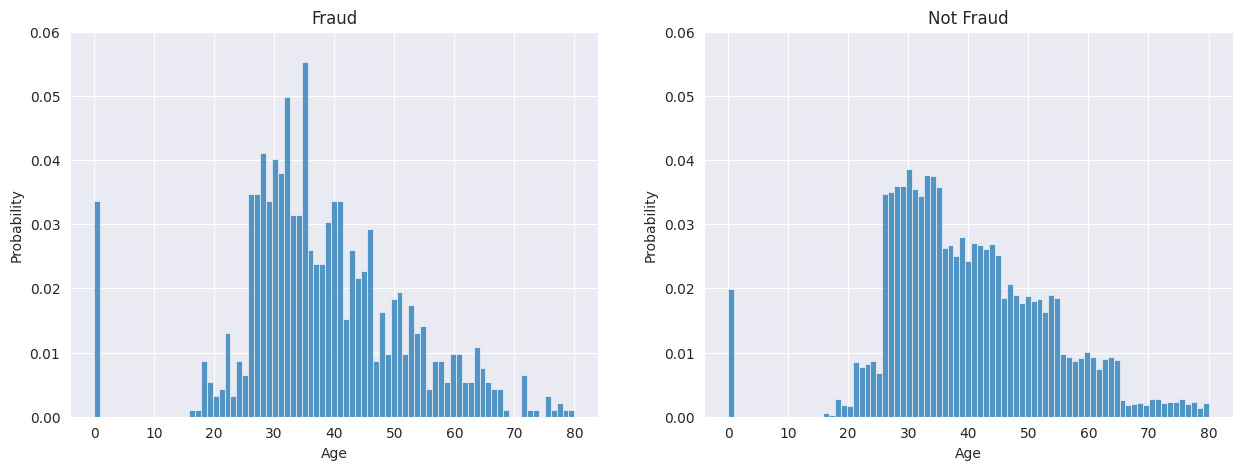

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(df['Age'][df['FraudFound_P']==1], bins=81, stat='probability', ax=ax1).set(title='Fraud', ylim=(0, 0.06))
sns.histplot(df['Age'][df['FraudFound_P']==0], bins=81, stat='probability', ax=ax2).set(title='Not Fraud', ylim=(0, 0.06))

For Fraud, there is a clear difference in the age distribution compared to the Not Fraud.

Text(0.5, 0.98, 'The distribution of fraud cases by age for Female and Male')

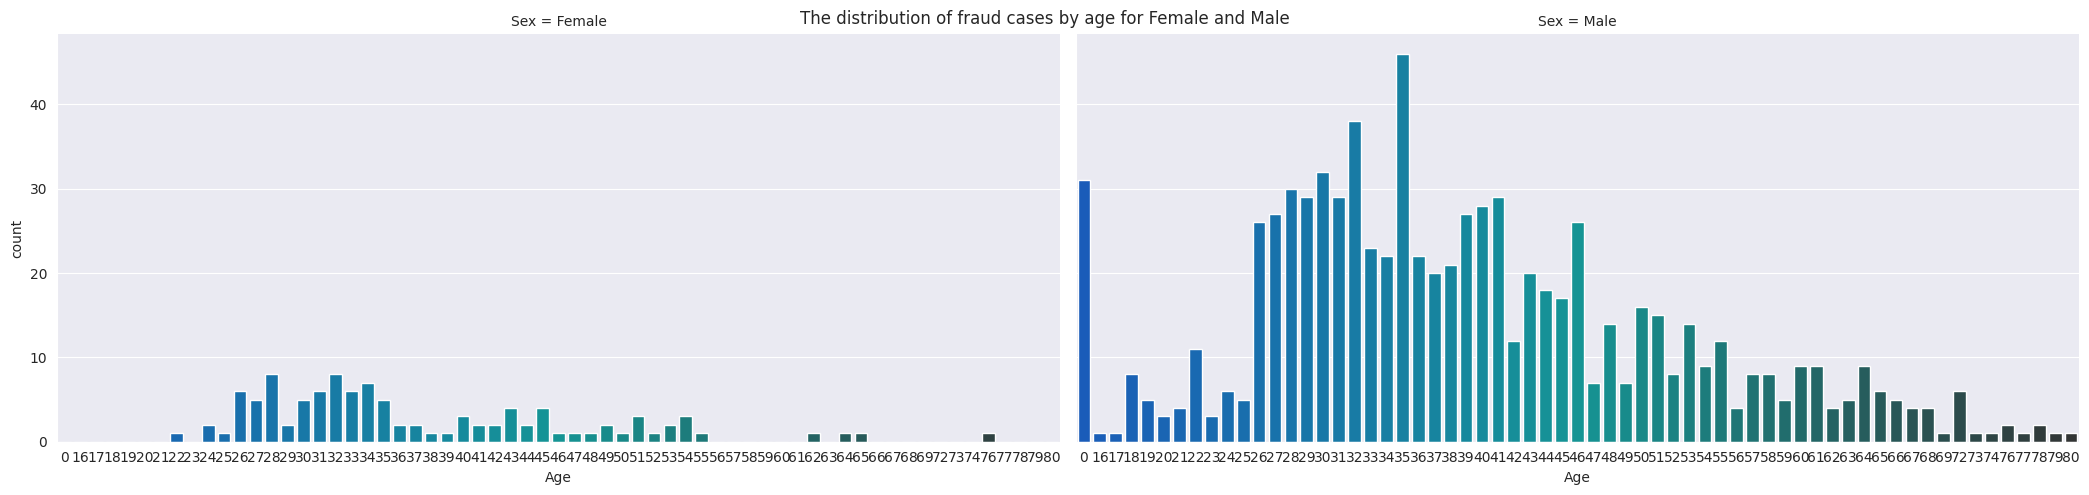

In [ ]:
sns.catplot(data=df[df['FraudFound_P']==1], x='Age',  col='Sex',
            col_order=['Female', 'Male'],
            kind='count', height=5, aspect=2.1, palette='winter_d')
plt.suptitle('The distribution of fraud cases by age for Female and Male')

Text(0, 0.5, 'Probability of fraud')

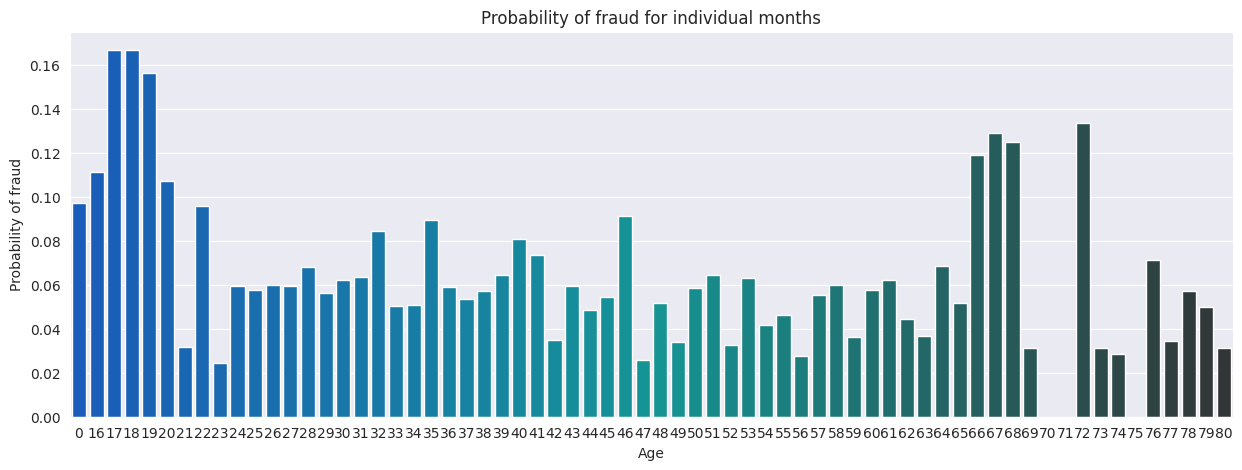

In [ ]:
df_age = df.groupby('Age').FraudFound_P.mean().reset_index()

plt.figure(figsize=(15,5))
sns.barplot(data=df_age, x='Age', y='FraudFound_P', palette='winter_d')
plt.title('Probability of fraud for individual months')
plt.ylabel('Probability of fraud')

 There are ages at which the risk of fraud is higher than at other ages. The highest probability of fraud is for the age of 17, 18 and 19. While the probability is equal zero for the age of 70, 71 and 75.

'AgeOfPolicyHolder'

In [ ]:
df['AgeOfPolicyHolder'].unique()

array(['26 to 30', '31 to 35', '41 to 50', '51 to 65', '21 to 25',
       '36 to 40', '16 to 17', 'over 65', '18 to 20'], dtype=object)

Text(0.5, 1.0, 'Number of claims by "AgeOfPolicyHolder"')

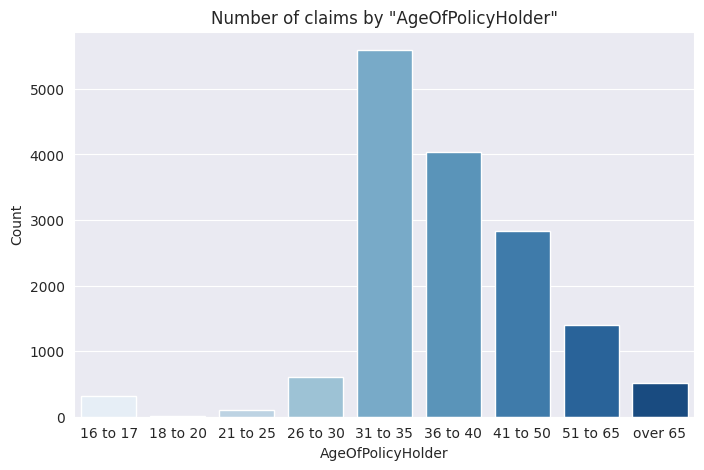

In [ ]:
holder_age_order = ['16 to 17','18 to 20', '21 to 25', '26 to 30', '31 to 35', '36 to 40', '41 to 50', '51 to 65', 'over 65']

df_age_holder_counts = df['AgeOfPolicyHolder'].value_counts().reset_index()
df_age_holder_counts.columns = ['AgeOfPolicyHolder', 'Count']

plt.figure(figsize=(8,5))
sns.barplot(data=df_age_holder_counts, x='AgeOfPolicyHolder', y='Count',
            order=holder_age_order, palette='Blues')

plt.title('Number of claims by "AgeOfPolicyHolder"')

Most cases of claim occur in the age group of 31 to 35 years.

'Make'

In [ ]:
px.pie(df, names='Make',
       width=600, height=450,
       color_discrete_sequence=px.colors.sequential.Blues_r,
       title='Claims by "Make"')

Pontiac, Toyota, Honda, Mazda and Chevrolet are the top 5 makes involved in claims.

'PolicyType'

In [ ]:
px.pie(df, names='PolicyType',
       width=600, height=450,
       color_discrete_sequence=px.colors.sequential.Blues_r,
       title='Claims by "PolicyType"')

There are three PolcyTypes with the highest number of claims: Sedan - Collission, Sedan - Liability and Sedan - All Perils

In [ ]:
fig = make_subplots(rows=1, cols=2, subplot_titles=('Fraud', 'Not Fraud'),
                    specs=[[{"type": "sunburst"}, {"type": "sunburst"}]])

fig1 = px.sunburst(df[df['FraudFound_P']==0], path=['BasePolicy','VehicleCategory'], color_discrete_sequence=px.colors.sequential.Blues_r)
fig.add_trace(fig1.data[0], row=1, col=1)

fig2 = px.sunburst(df[df['FraudFound_P']==1], path=['BasePolicy','VehicleCategory'], color_discrete_sequence=px.colors.sequential.Blues_r)
fig.add_trace(fig2.data[0], row=1, col=2)

fig.update_layout(title_text='Comparison of Fraud vs. Not Fraud for features: "BasePolicy" and "VehicleCategory"',
                  width=800, height=500, title_x=0.5,
                  sunburstcolorway = px.colors.qualitative.Prism)

fig.show()

Especially interesting is the very low number of fraud for 'Liability'.

'DayOfWeek'

Text(0.5, 1.0, 'Number of claims by "DayOfWeek"')

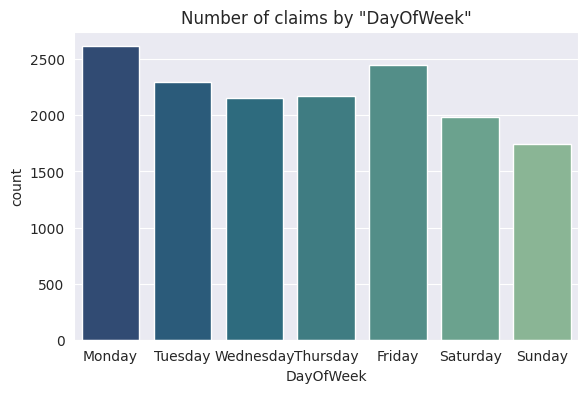

In [ ]:
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(6.5,4))
sns.countplot(data=df, x='DayOfWeek', order=day_order, palette='crest_r')

plt.title('Number of claims by "DayOfWeek"')

The highest probability of claim fraud is for Sunday

'VehiclePrice'

Text(0.5, 1.0, 'Number of claims by "VehiclePrice"')

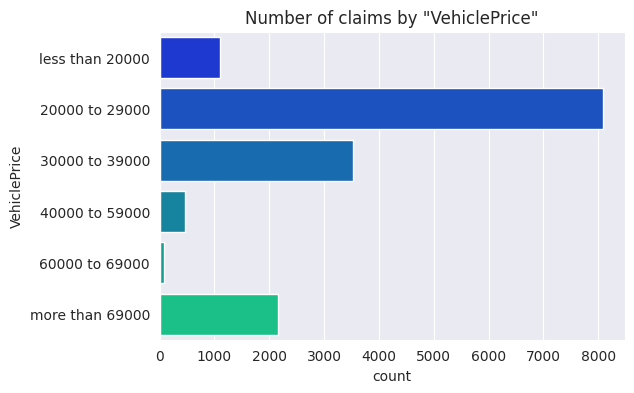

In [ ]:
vehicle_price_order = ['less than 20000', '20000 to 29000', '30000 to 39000', '40000 to 59000', '60000 to 69000', 'more than 69000']

plt.figure(figsize=(6, 4))
sns.countplot(data=df, y='VehiclePrice',
              order=vehicle_price_order, palette='winter')

plt.title('Number of claims by "VehiclePrice"')

The ranges of vehicle prices with the highest probability of fraud claims are 'less than 20000' and 'more than 69000'

'Fault'

In [ ]:
px.sunburst(df, path=['Fault', 'FraudLabel'],
            width=600, height=450,
            color_discrete_sequence=px.colors.qualitative.Prism,
            title='Claims by "Fault"')

The graph shows that fraud cases are very rare for 'Third Party"

##Preprocessing data

The transformation of features into binary.

In [ ]:
df['PoliceReportFiled'] = df['PoliceReportFiled'].map(lambda x: 1 if x=='Yes' else 0 )
df['WitnessPresent'] = df['WitnessPresent'].map(lambda x: 1 if x=='Yes' else 0 )
df['Male'] = df['Sex'].map(lambda x: 1 if x=='Male' else 0)
df['ThirdParty'] = df['Fault'].map(lambda x: 1 if x=='Third Party' else 0)
df['Urban'] = df['AccidentArea'].map(lambda x: 1 if x=='Urban' else 0)
df['AgentType_External'] = df['AgentType'].map(lambda x: 1 if x=='External' else 0)

Deletion of the features

In [ ]:
df.drop(['PolicyNumber', 'RepNumber', 'Year', 'FraudLabel', 'Sex', 'Fault', 'AccidentArea', 'AgentType'], axis=1, inplace=True)

#Feature transformation

Categorical ordinal features

In [ ]:
accident_days_order = ['none', '1 to 7', '8 to 15', '15 to 30', 'more than 30']
claim_days_order = ['none', '8 to 15', '15 to 30', 'more than 30']
past_claims_order = ['none', '1', '2 to 4', 'more than 4']
vehicle_age_order = ['new', '2 years', '3 years', '4 years', '5 years', '6 years', '7 years', 'more than 7']
num_suppliments_order = ['none', '1 to 2', '3 to 5', 'more than 5']
address_changes_order = ['no change', 'under 6 months', '1 year', '2 to 3 years', '4 to 8 years']
num_cars_order = ['1 vehicle', '2 vehicles', '3 to 4', '5 to 8', 'more than 8']

ordinal_features_dict = {'Month': month_order,
                         'DayOfWeek': day_order,
                         'DayOfWeekClaimed': day_order,
                         'MonthClaimed': month_order,
                         'VehiclePrice': vehicle_price_order,
                         'Days_Policy_Accident': accident_days_order,
                         'Days_Policy_Claim': claim_days_order,
                         'PastNumberOfClaims': past_claims_order,
                         'AgeOfVehicle': vehicle_age_order,
                         'AgeOfPolicyHolder': holder_age_order,
                         'NumberOfSuppliments': num_suppliments_order,
                         'AddressChange_Claim': address_changes_order,
                         'NumberOfCars':  num_cars_order}

In [ ]:
ordinal_features = ['Month', 'DayOfWeek', 'DayOfWeekClaimed', 'MonthClaimed', 'VehiclePrice',
                   'Days_Policy_Accident', 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle',
                   'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

df_o = df[ordinal_features].copy()

In [ ]:
for key in ordinal_features_dict:
  map_dict = {}
  for i, cat in enumerate(ordinal_features_dict[key]):
    map_dict[cat] = i+1
  new_column = key + '_ord'
  df_o[new_column] = df_o[key].map(map_dict)
  df_o[new_column] = df_o[new_column].astype('int')

df_o.drop(ordinal_features, axis=1, inplace=True)
df_o.sample(3)

,Month_ord,DayOfWeek_ord,DayOfWeekClaimed_ord,MonthClaimed_ord,VehiclePrice_ord,Days_Policy_Accident_ord,Days_Policy_Claim_ord,PastNumberOfClaims_ord,AgeOfVehicle_ord,AgeOfPolicyHolder_ord,NumberOfSuppliments_ord,AddressChange_Claim_ord,NumberOfCars_ord
2968,4,1,3,5,2,1,4,2,5,4,2,1,1
4905,7,2,1,7,2,5,4,3,7,5,1,1,1
10025,10,5,2,1,2,5,4,3,8,6,1,1,1


Categorical nominal features

In [ ]:
df.groupby(['Make', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
Make,,
Pontiac,3624.0,213.0
Toyota,2935.0,186.0
Honda,2621.0,179.0
Mazda,2231.0,123.0
Chevrolet,1587.0,94.0
Accura,413.0,59.0
Ford,417.0,33.0
Saab,97.0,11.0
VW,275.0,8.0


In [ ]:
df.groupby(['MaritalStatus', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
MaritalStatus,,
Married,9986,639
Single,4405,278
Divorced,73,3
Widow,32,3


In [ ]:
df.groupby(['PolicyType', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
PolicyType,,
Sedan - All Perils,3675.0,411.0
Sedan - Collision,5200.0,384.0
Sport - Collision,300.0,48.0
Utility - All Perils,299.0,41.0
Sedan - Liability,4951.0,36.0
Utility - Collision,27.0,3.0
Sport - All Perils,22.0,0.0
Sport - Liability,1.0,0.0
Utility - Liability,21.0,0.0


In [ ]:
df.groupby(['BasePolicy', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
BasePolicy,,
All Perils,3996,452
Collision,5527,435
Liability,4973,36


In [ ]:
df.groupby(['VehicleCategory', 'FraudFound_P']).FraudFound_P.count().unstack().fillna(0).sort_values(by=1, ascending=False)

FraudFound_P,0,1
VehicleCategory,,
Sedan,8875,795
Sport,5274,84
Utility,347,44


In [ ]:
df.drop(['VehicleCategory', 'BasePolicy'], axis=1, inplace=True)

In [ ]:
features_to_transform = ['Make', 'MaritalStatus', 'PolicyType']

df_t = df[features_to_transform]

In [ ]:
# for col in features_to_transform:
#   df[col] = df[col].astype('category')

In [ ]:
df_t = pd.get_dummies(df_t)

In [ ]:
df_t['Make_Other'] = df_t['Make_Jaguar'] + df_t['Make_Lexus'] + df_t['Make_Ferrari'] + df_t['Make_Porche']
df_t.drop(['Make_Jaguar', 'Make_Lexus', 'Make_Ferrari', 'Make_Porche'], axis=1, inplace=True)

In [ ]:
df_t['PolicyType_Other'] = df_t['PolicyType_Sport - All Perils'] + df_t['PolicyType_Sport - Liability'] + df_t['PolicyType_Utility - Liability']
df_t.drop(['PolicyType_Sport - All Perils', 'PolicyType_Sport - Liability', 'PolicyType_Utility - Liability'], axis=1, inplace=True)

Numerical features

In [ ]:
numerical_features = ['WeekOfMonth', 'WeekOfMonthClaimed', 'Age', 'Deductible',
                      'DriverRating', 'PoliceReportFiled', 'WitnessPresent',
                      'Male', 'ThirdParty', 'Urban', 'AgentType_External']

df_n = df[numerical_features].copy()

#Metrics

In [ ]:
skf = StratifiedKFold(n_splits=5)

In [ ]:
def calculate_metrics(y,y_pred):
    metrics = {'F1': [round(f1_score(y, y_pred),4)],
         'P-R': [round(average_precision_score(y, y_pred),4)],
         'ROC-AUC': [round(roc_auc_score(y, y_pred),4)],
         'recall': [round(recall_score(y, y_pred),4)],
         'precision': [round(precision_score(y, y_pred),4)],
         'accuracy': [round(accuracy_score(y, y_pred),4)]}

    return pd.DataFrame.from_dict(metrics)

In [ ]:
def get_result(model, X_train, X_val, y_train, y_val):

  model.fit(X_train, y_train)
  cvs = cross_val_score(model, cv=skf, X=X_train, y=y_train, scoring='f1')

  y_train_pred = model.predict(X_train)
  metrics_train = calculate_metrics(y_train, y_train_pred)

  y_val_pred = model.predict(X_val)
  metrics_val = calculate_metrics(y_val, y_val_pred)

  metrics = pd.concat([metrics_train, metrics_val]).set_index([pd.Index(['TRAIN', 'VAL'])])

  return y_train_pred, y_val_pred, metrics

In [ ]:
imbalance_ratio = df.FraudFound_P.value_counts()[0] / df.FraudFound_P.value_counts()[1]

In [ ]:
scale_pos_weight = df.FraudFound_P.value_counts()[1] / df.FraudFound_P.value_counts()[0]

#X i y

For CatBoost

In [ ]:
# X1 = df.copy()
# X1.drop('FraudFound_P', axis=1, inplace=True)
# y1 = df['FraudFound_P']

For other models

In [ ]:
X2 = pd.merge(df_n, df_o, how='left', left_index=True, right_index=True)
X2 = pd.merge(X2, df_t, how='left', left_index=True, right_index=True)
y2 = df['FraudFound_P']

#Feature selection

##RFECV

In [ ]:
lgb_model = lgb.LGBMClassifier(verbose=-1, is_unbalance=True)

rfe_lgb = RFECV(estimator=lgb_model, cv=skf, scoring='f1')

In [ ]:
rfe_lgb.fit(X2, y2)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(is_unbalance=True, verbose=-1), scoring='f1')

In [ ]:
print(len(rfe_lgb.feature_names_in_))
rfe_lgb_feats = list(rfe_lgb.feature_names_in_)

51


#Split on a training and test set

In [ ]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.25, random_state=6, stratify=y2)
X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.3, random_state=6, stratify=y2_train)

print(f'Train data set: {X2_train.shape}, Frauds: {y2_train.sum()}')
print(f'Validation data set: {X2_val.shape}, Frauds: {y2_val.sum()}')
print(f'Test data set: {X2_test.shape}, Frauds: {y2_test.sum()}')

Train data set: (8094, 51), Frauds: 484
Validation data set: (3470, 51), Frauds: 208
Test data set: (3855, 51), Frauds: 231


#Models

##Maximizing F1
>Since we are dealing with a binary classification problem with imbalanced data, the F1 score is a better evaluation metric than accuracy. It can help in minimizing false negatives.

###XGBoost

In [ ]:
def objective_XGB(trial):

  params = {'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'scale_pos_weight': imbalance_ratio,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'lambda': trial.suggest_float('lambda', 1, 10),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 6,
            'device': 'gpu'}

  optuna_model = xgb.XGBClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='f1')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_XGB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-10 17:02:21,526] A new study created in memory with name: no-name-c9ed1f99-313b-440a-83f9-a191e9f69ba6


In [ ]:
study_XGB.optimize(objective_XGB, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-10-10 17:02:28,904] Trial 0 finished with value: 0.16712641576283677 and parameters: {'n_estimators': 547, 'max_depth': 6, 'learning_rate': 0.08391062107520486, 'lambda': 1.375269631527249, 'alpha': 1.9689101194237115, 'colsample_bytree': 0.7165364449443681, 'subsample': 0.6708721535349751, 'min_child_weight': 5}. Best is trial 0 with value: 0.16712641576283677.
[I 2023-10-10 17:02:32,631] Trial 1 finished with value: 0.22813843557048155 and parameters: {'n_estimators': 268, 'max_depth': 9, 'learning_rate': 0.04943272834979867, 'lambda': 7.622938957138212, 'alpha': 5.662327707993419, 'colsample_bytree': 0.7052010201583099, 'subsample': 0.7517485671269156, 'min_child_weight': 10}. Best is trial 1 with value: 0.22813843557048155.
[I 2023-10-10 17:02:39,598] Trial 2 finished with value: 0.15139132409013056 and parameters: {'n_estimators': 510, 'max_depth': 7, 'learning_rate': 0.08886408896859647, 'lambda': 8.413834893134691, 'alpha': 1.4902705704011918, 'colsample_bytree': 0.80304

In [ ]:
params_XGB = study_XGB.best_params
params_XGB

{'n_estimators': 350,
 'max_depth': 11,
 'learning_rate': 0.016864179097943834,
 'lambda': 7.806032611354806,
 'alpha': 3.8725834136909545,
 'colsample_bytree': 0.5817037486185315,
 'subsample': 0.38643842934779327,
 'min_child_weight': 6}

In [ ]:
model_XGB = xgb.XGBClassifier(**params_XGB, random_state=6, objective='binary:logistic',
            eval_metric='logloss', scale_pos_weight=imbalance_ratio)
y_train_XGB, y_val_XGB, metrics_XGB = get_result(model_XGB, X2_train, X2_val, y2_train, y2_val)
metrics_XGB

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.4513,0.2845,0.9041,0.9525,0.2957,0.8615
VAL,0.2670,0.1244,0.6953,0.5577,0.1755,0.8164


In [ ]:
optuna.visualization.plot_parallel_coordinate(study_XGB)

In [ ]:
optuna.visualization.plot_optimization_history(study_XGB)

###LightGBM

In [ ]:
def objective_LGBM(trial):

  params = {'objective': 'binary',
            'metric': 'f1',
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators' : trial.suggest_int('n_estimators', 20, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'scale_pos_weight': imbalance_ratio,
            'random_state': 6,
            'verbose': -1}

  optuna_model = lgb.LGBMClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='f1')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_LGBM = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-10 18:16:59,610] A new study created in memory with name: no-name-49daa87a-fca3-4a42-b2f4-df5a85a3482f


In [ ]:
study_LGBM.optimize(objective_LGBM, n_trials=500, show_progress_bar=True)

  0%|          | 0/500 [00:00<?, ?it/s]

[I 2023-10-10 18:17:03,037] Trial 0 finished with value: 0.17362310352849297 and parameters: {'max_depth': 14, 'n_estimators': 212, 'learning_rate': 0.08391062107520486, 'num_leaves': 31, 'min_child_samples': 15, 'colsample_bytree': 0.6760416513649923, 'subsample': 0.6708721535349751}. Best is trial 0 with value: 0.17362310352849297.
[I 2023-10-10 18:17:04,558] Trial 1 finished with value: 0.2186777395795873 and parameters: {'max_depth': 8, 'n_estimators': 214, 'learning_rate': 0.06602674889764812, 'num_leaves': 143, 'min_child_samples': 75, 'colsample_bytree': 0.6144291295994151, 'subsample': 0.7052010201583099}. Best is trial 1 with value: 0.2186777395795873.
[I 2023-10-10 18:17:10,679] Trial 2 finished with value: 0.1429379574962948 and parameters: {'max_depth': 11, 'n_estimators': 595, 'learning_rate': 0.08378723772296573, 'num_leaves': 136, 'min_child_samples': 89, 'colsample_bytree': 0.859007546056417, 'subsample': 0.33813215547564823}. Best is trial 1 with value: 0.2186777395795

In [ ]:
params_LGBM = study_LGBM.best_params
params_LGBM

{'max_depth': 11,
 'n_estimators': 102,
 'learning_rate': 0.015130116617787962,
 'num_leaves': 257,
 'min_child_samples': 57,
 'colsample_bytree': 0.9430929151177779,
 'subsample': 0.43241574863502497}

In [ ]:
model_LGBM = lgb.LGBMClassifier(**params_LGBM, objective='binary', metric='f1',
                                scale_pos_weight=imbalance_ratio, verbose=-1, random_state=6)
y_train_LGBM, y_val_LGBM, metrics_LGBM = get_result(model_LGBM, X2_train, X2_val, y2_train, y2_val)
metrics_LGBM

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.4730,0.3047,0.9160,0.9669,0.3130,0.8711
VAL,0.2585,0.1177,0.6772,0.5096,0.1732,0.8248


In [ ]:
optuna.visualization.plot_parallel_coordinate(study_LGBM)

In [ ]:
optuna.visualization.plot_optimization_history(study_LGBM)

###CatBoost

In [ ]:
def objective_CB(trial):

  params = {'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.3, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'loss_function': 'Logloss',
            'eval_metric': 'F1',
            'class_weights': [1, 17],
            'random_state': 6,
            'verbose': False,
            'task_type': 'GPU'}

  optuna_model = ctb.CatBoostClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='f1')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-10 19:02:54,138] A new study created in memory with name: no-name-650c1e23-1689-4c48-aab8-9d241ac94009


In [ ]:
study_CB.optimize(objective_CB, n_trials=400, show_progress_bar=True)

  0%|          | 0/400 [00:00<?, ?it/s]

[I 2023-10-10 19:10:28,280] Trial 4 finished with value: 0.24488897746178448 and parameters: {'n_estimators': 384, 'max_depth': 7, 'learning_rate': 0.021234175694254884, 'l2_leaf_reg': 9.618825659227015, 'bagging_temperature': 0.5822794091144439, 'border_count': 80}. Best is trial 4 with value: 0.24488897746178448.
[I 2023-10-10 19:11:13,550] Trial 5 finished with value: 0.10657737694620181 and parameters: {'n_estimators': 387, 'max_depth': 10, 'learning_rate': 0.033005265004075156, 'l2_leaf_reg': 7.041784887453524, 'bagging_temperature': 0.7193041391973816, 'border_count': 192}. Best is trial 4 with value: 0.24488897746178448.
[I 2023-10-10 19:11:29,593] Trial 6 finished with value: 0.24362591730709315 and parameters: {'n_estimators': 475, 'max_depth': 5, 'learning_rate': 0.03282706877242564, 'l2_leaf_reg': 4.622252581330957, 'bagging_temperature': 0.8225575020294895, 'border_count': 194}. Best is trial 4 with value: 0.24488897746178448.
[I 2023-10-10 19:12:09,458] Trial 7 finished wi

In [ ]:
params_CB = study_CB.best_params
params_CB

{'n_estimators': 135,
 'max_depth': 3,
 'learning_rate': 0.011132541504315897,
 'l2_leaf_reg': 9.809064362791359,
 'bagging_temperature': 0.4008007528677176,
 'border_count': 255}

In [ ]:
model_CB = ctb.CatBoostClassifier(**params_CB,eval_metric='F1', class_weights=[1, 17],
                                  loss_function='Logloss', random_seed=6,  verbose=False)
y_train_CB, y_val_CB, metrics_CB = get_result(model_CB, X2_train, X2_val, y2_train, y2_val)
metrics_CB

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2221,0.1228,0.7665,0.9566,0.1256,0.5992
VAL,0.2246,0.1239,0.7668,0.9471,0.1274,0.6081


In [ ]:
model_CB = ctb.CatBoostClassifier(**params_CB, class_weights=[1, 17],
                                   random_seed=6, eval_metric='F1', verbose=False)
y_train_CB, y_val_CB, metrics_CB = get_result(model_CB, X2_train, X2_val, y2_train, y2_val)
metrics_CB

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_CB)

In [ ]:
optuna.visualization.plot_optimization_history(study_CB)

##Maximizing Recall
>

###XGBoost

In [ ]:
def objective_XGB(trial):

  params = {'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'tree_method': 'hist',
            'scale_pos_weight': imbalance_ratio,
            'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 12),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'lambda': trial.suggest_float('lambda', 1, 10),
            'alpha': trial.suggest_float('alpha', 1, 10),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'random_state': 6,
            'device': 'gpu'}

  optuna_model = xgb.XGBClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='recall')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_XGB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-09 18:49:34,586] A new study created in memory with name: no-name-dabe869e-d94b-446e-a2ab-f990bff03531


In [ ]:
study_XGB.optimize(objective_XGB, n_trials=500, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-09 18:49:41,034] Trial 0 finished with value: 0.25008591065292096 and parameters: {'n_estimators': 458, 'max_depth': 5, 'learning_rate': 0.08391062107520486, 'lambda': 1.375269631527249, 'alpha': 1.9689101194237115, 'colsample_bytree': 0.5991015435641779, 'subsample': 0.5345191885708934, 'min_child_weight': 5}. Best is trial 0 with value: 0.25008591065292096.
[I 2023-10-09 18:49:43,669] Trial 1 finished with value: 0.4897981099656358 and parameters: {'n_estimators': 234, 'max_depth': 7, 'learning_rate': 0.04943272834979867, 'lambda': 7.622938957138212, 'alpha': 5.662327707993419, 'colsample_bytree': 0.5830700142238955, 'subsample': 0.6489015449366379, 'min_child_weight': 10}. Best is trial 1 with value: 0.4897981099656358.
[I 2023-10-09 18:49:47,844] Trial 2 finished with value: 0.22940292096219933 and parameters: {'n_estimators': 428, 'max_depth': 6, 'learning_rate': 0.08886408896859647, 'lambda': 8.413834893134691, 'alpha': 1.4902705704011918, 'colsample_bytree': 0.7214508

In [ ]:
params_XGB = study_XGB.best_params
params_XGB

{'n_estimators': 117,
 'max_depth': 3,
 'learning_rate': 0.010126383279916744,
 'lambda': 4.610096648371647,
 'alpha': 1.2717097005687097,
 'colsample_bytree': 0.981215442841233,
 'subsample': 0.9087003735528618,
 'min_child_weight': 8}

In [ ]:
model_XGB = xgb.XGBClassifier(**params_XGB, random_state=6, objective='binary:logistic',
            eval_metric='logloss', scale_pos_weight=imbalance_ratio)
y_train_XGB, y_val_XGB, metrics_XGB = get_result(model_XGB, X2_train, X2_val, y2_train, y2_val)
metrics_XGB

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2297,0.1266,0.7714,0.9401,0.1308,0.6229
VAL,0.2266,0.1231,0.7595,0.9087,0.1295,0.6282


In [ ]:
optuna.visualization.plot_parallel_coordinate(study_XGB)

In [ ]:
optuna.visualization.plot_optimization_history(study_XGB)

###LightGBM

In [ ]:
def objective_LGBM(trial):

  params = {'objective': 'binary',
            'metric': 'recall',
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators' : trial.suggest_int('n_estimators', 20, 600),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'num_leaves': trial.suggest_int('num_leaves', 20, 300),
            'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.2, 1.0),
            'subsample': trial.suggest_float('subsample', 0.3, 1.0),
            'scale_pos_weight': imbalance_ratio,
            'device': 'gpu',
            'random_state': 6,
            'verbose': -1}

  optuna_model = lgb.LGBMClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='recall')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_LGBM = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-09 18:36:53,769] A new study created in memory with name: no-name-e9f56694-9d36-41d6-bca5-2efe3fb0609c


In [ ]:
study_LGBM.optimize(objective_LGBM, n_trials=500, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-09 18:36:57,616] Trial 0 finished with value: 0.23354810996563574 and parameters: {'max_depth': 14, 'n_estimators': 199, 'learning_rate': 0.08230168318272535, 'num_leaves': 31, 'min_child_samples': 15, 'colsample_bytree': 0.6355468577856163, 'subsample': 0.7649086810964107}. Best is trial 0 with value: 0.23354810996563574.
[I 2023-10-09 18:36:59,121] Trial 1 finished with value: 0.39254725085910647 and parameters: {'max_depth': 8, 'n_estimators': 201, 'learning_rate': 0.06262942378741293, 'num_leaves': 143, 'min_child_samples': 75, 'colsample_bytree': 0.5662327707993419, 'subsample': 0.7894293001130785}. Best is trial 1 with value: 0.39254725085910647.
[I 2023-10-09 18:37:03,351] Trial 2 finished with value: 0.1301546391752577 and parameters: {'max_depth': 11, 'n_estimators': 496, 'learning_rate': 0.0821659614952623, 'num_leaves': 136, 'min_child_samples': 89, 'colsample_bytree': 0.8413834893134692, 'subsample': 0.5272372539111774}. Best is trial 1 with value: 0.392547250859

In [ ]:
params_LGBM = study_LGBM.best_params
params_LGBM

{'max_depth': 3,
 'n_estimators': 363,
 'learning_rate': 0.008270039899196363,
 'num_leaves': 266,
 'min_child_samples': 48,
 'colsample_bytree': 0.8131396499178887,
 'subsample': 0.8337472842825591}

In [ ]:
model_LGBM = lgb.LGBMClassifier(**params_LGBM, objective='binary', metric='recall',
                                scale_pos_weight=imbalance_ratio, verbose=-1, random_state=6)
y_train_LGBM, y_val_LGBM, metrics_LGBM = get_result(model_LGBM, X2_train, X2_val, y2_train, y2_val)
metrics_LGBM

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2371,0.1305,0.7768,0.9298,0.1359,0.6422
VAL,0.2330,0.1259,0.7615,0.8894,0.1341,0.6490


In [ ]:
optuna.visualization.plot_parallel_coordinate(study_LGBM)

In [ ]:
optuna.visualization.plot_optimization_history(study_LGBM)

###CatBoost

In [ ]:
# cat_features = ['Month', 'DayOfWeek', 'Make', 'DayOfWeekClaimed', 'MonthClaimed',
#                 'MaritalStatus', 'PolicyType', 'VehiclePrice', 'Days_Policy_Accident',
#                 'Days_Policy_Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder',
#                 'NumberOfSuppliments', 'AddressChange_Claim', 'NumberOfCars']

In [ ]:
# cat_ord_features = ['Month_ord', 'DayOfWeek_ord', 'DayOfWeekClaimed_ord', 'MonthClaimed_ord',
#                     'VehiclePrice_ord', 'Days_Policy_Accident_ord', 'Days_Policy_Claim_ord',
#                     'PastNumberOfClaims_ord', 'AgeOfVehicle_ord', 'AgeOfPolicyHolder_ord',
#                     'NumberOfSuppliments_ord', 'AddressChange_Claim_ord', 'NumberOfCars_ord']

In [ ]:
def objective_CB(trial):

  params = {'n_estimators': trial.suggest_int('n_estimators', 100, 600),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 10),
            'bagging_temperature': trial.suggest_float('bagging_temperature', 0.3, 1),
            'colsample_bylevel': trial.suggest_float('bagging_temperature', 0.3, 1),
            'border_count': trial.suggest_int('border_count', 32, 255),
            'loss_function': 'Logloss',
            'class_weights': [1, 17],
            'random_state': 6,
            'verbose': False,
            'task_type': 'GPU',
            'devices': '0:1'}

  optuna_model = ctb.CatBoostClassifier(**params)
  cvs = cross_val_score(optuna_model, cv=skf, X=X2_train, y=y2_train, scoring='recall')
  score = cvs.mean()

  return score

In [ ]:
sampler = optuna.samplers.TPESampler(seed=6)
study_CB = optuna.create_study(direction='maximize', sampler=sampler)

[I 2023-10-09 19:02:43,895] A new study created in memory with name: no-name-ea8856c0-b95e-4765-abc6-ca7eb5d7453e


In [ ]:
study_CB.optimize(objective_CB, n_trials=400, show_progress_bar=True)

  0%|          | 0/200 [00:00<?, ?it/s]

[I 2023-10-09 19:03:13,860] Trial 0 finished with value: 0.25614261168384883 and parameters: {'n_estimators': 458, 'max_depth': 5, 'learning_rate': 0.08391062107520486, 'l2_leaf_reg': 1.375269631527249, 'bagging_temperature': 0.10765667993596795, 'border_count': 165}. Best is trial 0 with value: 0.25614261168384883.
[I 2023-10-09 19:03:28,056] Trial 1 finished with value: 0.5207259450171822 and parameters: {'n_estimators': 312, 'max_depth': 6, 'learning_rate': 0.04018670643459964, 'l2_leaf_reg': 6.6026748897648115, 'bagging_temperature': 0.4381414261088741, 'border_count': 196}. Best is trial 1 with value: 0.5207259450171822.
[I 2023-10-09 19:03:47,111] Trial 2 finished with value: 0.22315292096219932 and parameters: {'n_estimators': 307, 'max_depth': 7, 'learning_rate': 0.06808195863060344, 'l2_leaf_reg': 9.912018442360747, 'bagging_temperature': 0.8198581969218414, 'border_count': 124}. Best is trial 1 with value: 0.5207259450171822.
[I 2023-10-09 19:04:31,979] Trial 3 finished with 

In [ ]:
params_CB = study_CB.best_params
params_CB

{'n_estimators': 135,
 'max_depth': 3,
 'learning_rate': 0.011132541504315897,
 'l2_leaf_reg': 9.809064362791359,
 'bagging_temperature': 0.4008007528677176,
 'border_count': 255}

In [ ]:
model_CB = ctb.CatBoostClassifier(**params_CB, class_weights=[1, 17],
                                   random_seed=6, eval_metric='Recall', verbose=False)
y_train_CB, y_val_CB, metrics_CB = get_result(model_CB, X2_train, X2_val, y2_train, y2_val)
metrics_CB

,F1,P-R,ROC-AUC,recall,precision,accuracy
TRAIN,0.2221,0.1228,0.7665,0.9566,0.1256,0.5992
VAL,0.2246,0.1239,0.7668,0.9471,0.1274,0.6081


In [ ]:
model_CB = ctb.CatBoostClassifier(**params_CB, class_weights=[1, 17],
                                   random_seed=6, eval_metric='F1', verbose=False)
y_train_CB, y_val_CB, metrics_CB = get_result(model_CB, X2_train, X2_val, y2_train, y2_val)
metrics_CB

In [ ]:
optuna.visualization.plot_parallel_coordinate(study_CB)

In [ ]:
optuna.visualization.plot_optimization_history(study_CB)

#Summary

In [ ]:
result = pd.concat([metrics_XGB, metrics_LGBM, metrics_CB], keys=['XGBoost', 'LightGBM', 'CatBoost'])
result

F1     P-R  ROC-AUC  recall  precision  accuracy
XGBoost  TRAIN  0.2297  0.1266   0.7714  0.9401     0.1308    0.6229
         VAL    0.2266  0.1231   0.7595  0.9087     0.1295    0.6282
LightGBM TRAIN  0.2371  0.1305   0.7768  0.9298     0.1359    0.6422
         VAL    0.2330  0.1259   0.7615  0.8894     0.1341    0.6490
CatBoost TRAIN  0.2221  0.1228   0.7665  0.9566     0.1256    0.5992
         VAL    0.2246  0.1239   0.7668  0.9471     0.1274    0.6081

In [ ]:
best_model = model_CB

X_test = X2_test.copy()
y_test = y2_test

y_test_pred = best_model.predict(X_test)

In [ ]:
calculate_metrics(y_test, y_test_pred)

,F1,P-R,ROC-AUC,recall,precision,accuracy
0,0.2204,0.1221,0.7661,0.9654,0.1244,0.5907


In [ ]:
cf_matrix = confusion_matrix(y_test, y_test_pred)
cf_matrix

array([[2054, 1570],
       [   8,  223]])

<Axes: >

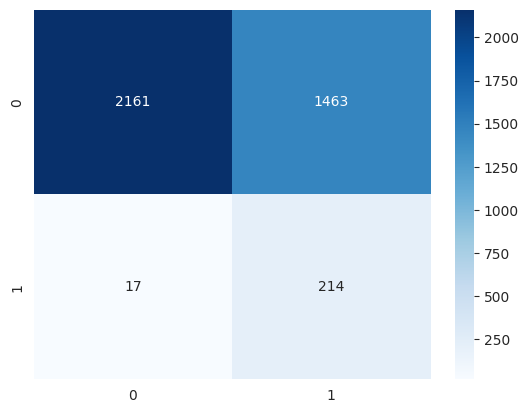

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

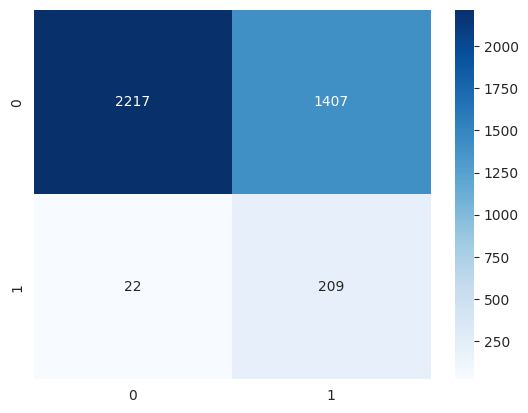

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

catboost

<Axes: >

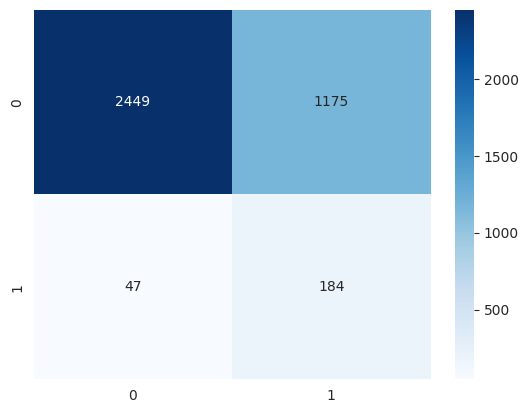

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

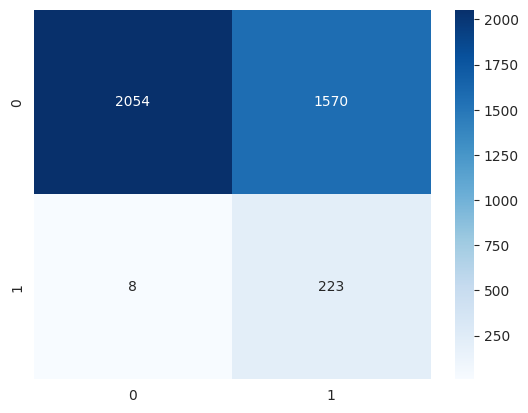

In [ ]:
sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

<Axes: >

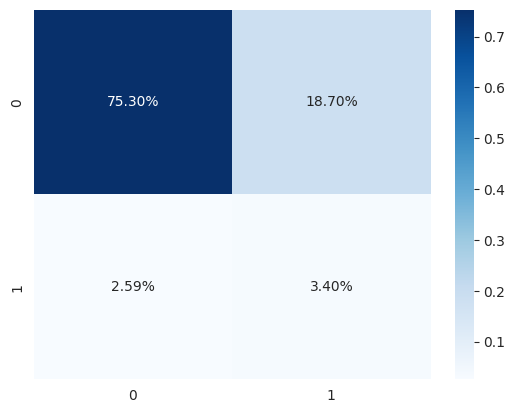

In [ ]:
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt = '.2%',
            cmap='Blues')

##Shap

In [ ]:
explainer = shap.TreeExplainer(best_model)

In [ ]:
shap_values = explainer.shap_values(X_test)

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


In [ ]:
print('Feature significance chart')
shap.summary_plot(shap_values, X_test, plot_type='bar')